In [1]:
from anything_vae import (
    ResnetBlock2D,
    SelfAttention,
    Downsample2D,
    Upsample2D,
    DownEncoderBlock2D,
    UpDecoderBlock2D,
    UNetMidBlock2D,
    Encoder,
    Decoder,
    # AutoencoderKL,
    VGGPerceptualLoss
)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, models as torchvision_models
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
# import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 10
        # return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))


In [3]:
# class VGGPerceptualLoss(LightningModule):
#     def __init__(self, vgg_model):
#         super().__init__()
#         self.vgg = vgg_model
#         self.criterion = nn.MSELoss()
#         self.features = list(self.vgg.features[:16])
#         self.features = nn.Sequential(*self.features).eval()
        
#         for params in self.features.parameters():
#             params.requires_grad = False

#     def forward(self, x, y):
#         return self.criterion(self.features(x),self.features(y))

# class Colorizer(LightningModule):
#     def __init__(self, vae):
#         super().__init__()
#         self.model = vae
#         vgg_model = vgg16(weights=True)
#         self.loss_fn = VGGPerceptualLoss(vgg_model)
#         self.mse_loss_fn = nn.MSELoss()  # MSE Loss function

        
#         # device = "cuda" if torch.cuda.is_available() else "cpu"
#         # self.clip_model, _ = clip.load("ViT-B/32", device=device)
#         # self.clip_loss_fn = CLIPLoss(self.clip_model, "vibrant beautiful colorful", device)
# # 
#         self.hparams.learning_rate = 0.00001

#     def forward(self, x):
#         return self.model(x)
    
#     def configure_optimizers(self):
#         return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

#     def training_step(self, batch, batch_idx):
#         inputs, targets = batch
#         outputs = self(inputs).sample

#         perceptual_loss = self.loss_fn(outputs, targets)
#         # clip_loss = self.clip_loss_fn(outputs)
#         mse_loss = self.mse_loss_fn(outputs, targets)  # Compute MSE loss

#         # total_loss = perceptual_loss + clip_loss
#         total_loss = perceptual_loss + mse_loss
#         # total_loss = perceptual_loss
#         self.log('train_loss', total_loss)
#         self.log('perceptual_loss', perceptual_loss)
#         self.log('mse_loss', mse_loss)
#         return total_loss


In [4]:
class ColorizerOLD(nn.Module):
    def __init__(self):
        super(ColorizerOLD, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)  # Output 4 channels from quant_conv
        self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)  # Expect 4 channels here

        vgg_model = vgg16(weights=True)

        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.mse_loss_fn = nn.MSELoss()

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, z):
        z = self.post_quant_conv(z)
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        # Autoencoder forward pass
        z = self.encode(x)
        x_recon = self.decode(z)
        
        # Compute losses
        perceptual_loss = self.loss_fn(x_recon, x)
        mse_loss = self.mse_loss_fn(x_recon, x)
        total_loss = perceptual_loss + mse_loss
        
        return x_recon, total_loss

In [5]:
class ColorizerOLD(nn.Module):
    def __init__(self, pretrained_vae):
        super(ColorizerOLD, self).__init__()

        # Use pretrained encoder, decoder, quant_conv, and post_quant_conv
        self.encoder = pretrained_vae.encoder
        self.decoder = pretrained_vae.decoder
        self.quant_conv = pretrained_vae.quant_conv
        self.post_quant_conv = pretrained_vae.post_quant_conv

        vgg_model = vgg16(weights=True)

        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.mse_loss_fn = nn.MSELoss()

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)  # h: [batch_size, 8, H, W]

        # Split h into mean and logvar
        mean, logvar = torch.chunk(h, 2, dim=1)  # Each: [batch_size, 4, H, W]

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps  # z: [batch_size, 4, H, W]

        return z

    def decode(self, z):
        z = self.post_quant_conv(z)  # z: [batch_size, 4, H, W]
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)

        # Compute losses
        perceptual_loss = self.loss_fn(x_recon, x)
        mse_loss = self.mse_loss_fn(x_recon, x)
        total_loss = perceptual_loss + mse_loss

        return x_recon, total_loss


In [6]:
class Trainer:
    def __init__(self, model, dataset, device, batch_size=1, lr=1e-4, epochs=10):
        self.model = model.to(device)
        self.device = device
        self.epochs = epochs

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.model.train()

    def train(self):
        for epoch in range(self.epochs):
            total_loss = 0.0
            for i, (sketch, colored) in enumerate(self.dataloader):
                sketch, colored = sketch.to(self.device), colored.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                reconstructed, loss = self.model(sketch)

                # Backward pass
                loss.backward()

                # Optimize
                self.optimizer.step()

                total_loss += loss.item()

            # Print average loss for the epoch
            avg_loss = total_loss / len(self.dataloader)
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}")

In [7]:
pretrained_model = torch.load('anything-vae.pth', map_location='cpu')
# model = Colorizer(pretrained_model)

In [8]:
pretrained_model.post_quant_conv

Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))

In [9]:
model = ColorizerOLD(pretrained_model)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
pretrained_state_dict = pretrained_model.state_dict()

# Load the state dict into your model, but ignore missing loss_fn keys
missing_keys, unexpected_keys = model.load_state_dict(pretrained_state_dict, strict=False)

# Filter out the missing loss_fn keys, as they are not critical
filtered_missing_keys = [key for key in missing_keys if not key.startswith('loss_fn')]


In [11]:
filtered_missing_keys

[]

In [12]:
??model

Signature:       model(*args, **kwargs)
Type:            ColorizerOLD
String form:    
ColorizerOLD(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetB

In [13]:
assert len(filtered_missing_keys) == 0
assert len(unexpected_keys) == 0

In [14]:
data_folder = 'data/toy'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# logger = loggers.TensorBoardLogger("tb_logs")
# trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)

In [18]:
# trainer.fit(model, dataloader)

In [19]:
trainer = Trainer(model, training_dataset, device)
trainer.train()

Epoch [1/10], Loss: 0.3061
Epoch [2/10], Loss: 0.1935
Epoch [3/10], Loss: 0.1539
Epoch [4/10], Loss: 0.1321
Epoch [5/10], Loss: 0.1139
Epoch [6/10], Loss: 0.1026
Epoch [7/10], Loss: 0.0943
Epoch [8/10], Loss: 0.0898
Epoch [9/10], Loss: 0.0836
Epoch [10/10], Loss: 0.0774


In [20]:
trainer.train()

Epoch [1/10], Loss: 0.0743
Epoch [2/10], Loss: 0.0699
Epoch [3/10], Loss: 0.0669
Epoch [4/10], Loss: 0.0638
Epoch [5/10], Loss: 0.0603
Epoch [6/10], Loss: 0.0574
Epoch [7/10], Loss: 0.0556
Epoch [8/10], Loss: 0.0544
Epoch [9/10], Loss: 0.0550
Epoch [10/10], Loss: 0.0546


In [21]:
trainer.train()

Epoch [1/10], Loss: 0.0532
Epoch [2/10], Loss: 0.0551
Epoch [3/10], Loss: 0.0548
Epoch [4/10], Loss: 0.0676
Epoch [5/10], Loss: 0.0736
Epoch [6/10], Loss: 0.0809
Epoch [7/10], Loss: 0.0714
Epoch [8/10], Loss: 0.0616
Epoch [9/10], Loss: 0.0569
Epoch [10/10], Loss: 0.0479


In [24]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [25]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

ColorizerOLD(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (co

In [48]:
idx = 5
x, y = training_dataset[idx]
output = model(x.unsqueeze(0))

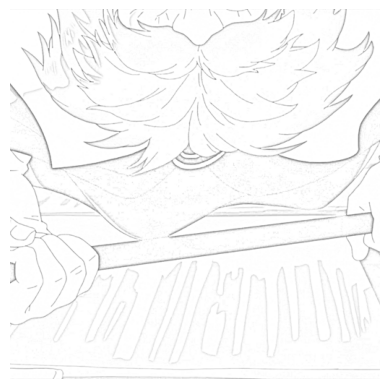

In [49]:
viewTensor(x)

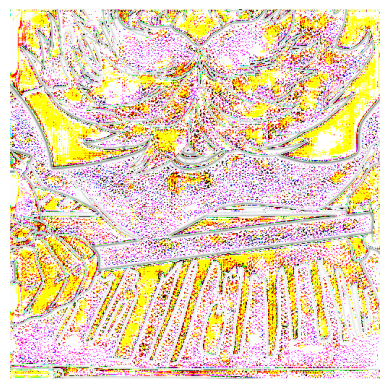

In [50]:
viewTensor(output[0])

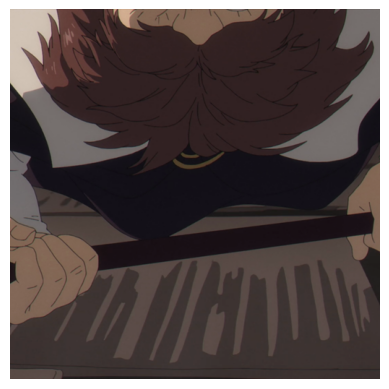

In [51]:
viewTensor(y)